<a href="https://colab.research.google.com/github/pbenito1/TFM/blob/main/RedesNeuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de dominios DGA utilizando redes neuronales
En este notebook se realizarán diversos experimentos de detección de dominios generados por DGA utilizando distintas arquitecturas de redes neuronales.

Una vez entrenadas las distintas arquitecturas se compararán los resultados, tanto en términos de *accuracy*, número de parámetros y tiempo de entrenamiento.

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer
from IPython.core.display import display, Markdown

In [2]:
# Estilos seaborn
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

In [3]:
# Cargamos datos
GDRIVE_PATH='/content/drive/MyDrive/TFM'
DATASET_PATH=os.path.join(GDRIVE_PATH, 'data_processed/dga.csv')
IMAGES_PATH=os.path.join(GDRIVE_PATH, 'img')
CHECKPOINTS_PATH=os.path.join(GDRIVE_PATH, 'checkpoints')

df = pd.read_csv(DATASET_PATH,index_col=0)

In [4]:
df.sample(10)

,domain,family,category,tld,sld,subdomains_number,digits,length,num_dashes,entropy,ratio_vc,3gram,4gram,5gram,6gram
77523,conjsepahisenglishhave.ru,gozi,malign,ru,conjsepahisenglishhave,2,0,22,0,3.538311,0.571429,20,19,14,7
232473,oqojssmknmwdqsme.com,sphinx,malign,com,oqojssmknmwdqsme,2,0,16,0,3.155639,0.230769,13,1,0,0
796132,gtstv.ru,benign,benign,ru,gtstv,2,0,5,0,1.921928,0.000000,3,2,1,0
287445,ahftxkarm.biz,torpig,malign,biz,ahftxkarm,2,0,9,0,2.947703,0.285714,7,3,0,0
803269,niea.org.ng,benign,benign,org.ng,niea,3,0,4,0,2.000000,3.000000,2,1,0,0
427265,17rplcldsifze1ktq2ux1gr50f5.org,gameover,malign,org,17rplcldsifze1ktq2ux1gr50f5,2,8,27,0,4.282484,0.125000,19,6,1,0
783490,baskino4.xyz,benign,benign,xyz,baskino4,2,1,8,0,3.000000,0.600000,6,5,4,3
846288,makemyhsrp.com,benign,benign,com,makemyhsrp,2,0,10,0,3.121928,0.250000,8,7,6,5
759670,thedrinkshop.com,benign,benign,com,thedrinkshop,2,0,12,0,3.418296,0.333333,10,9,8,7
979900,cnnbfdc.com,benign,benign,com,cnnbfdc,2,0,7,0,2.235926,0.000000,5,4,3,2


In [5]:
# Para probar el código tomamos un 10% del dataset original (aprox 10.000)
# Realizamos una muestra estratificada para que haya muestras de todas las familias

#df=df.groupby('family', group_keys=False).apply(lambda x: x.sample(frac=0.5))
df.shape

(1142536, 15)

In [6]:
X = np.array(df['domain'])

# Codificamos como 0 los dominios benignos y como 1 los malignos
Y = np.array([0 if x == 'benign' else 1 for x in df['category']])

# Obtiene un set (elementos únicos) de todos los caracteres utilizados en todos los dominios
# No hay ningún criterio para la ordenación, se asignan números según aparecen los caracteres.
valid_chars = {x:idx+1 for idx, x in enumerate(set(''.join(X)))}
# Se le suma 1 para UNKNOWN
max_features = len(valid_chars) + 1
# Se determina max_len como el dominio mas largo del dataset. 
# Se puede optar por fijarlo al valor especificado en el RFC
# La longitud máxima de un dominio es de 255 caracteres (incluyendo TLD, SLD, ...)
# RFC 1035 section 2.3.4.
max_len = max([len(i) for i in X])

# Recorre todos los caracteres de todos los dominios y los sustituye por su equivalente numérico
X = [[valid_chars[y] for y in x] for x in X]

# Añade padding hasta la máxima longitud
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=max_len)

# Dividimos el dataset en training (80%) y test (20%). 
# Utilizamos una semilla para poder reproducir los resultados
# Hacemos un muestreo estratificado de acuerdo al atributo 'family'
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42, stratify=df['family'])


In [7]:
#@title Hiperparámetros
LOSS_FUNCTION='binary_crossentropy'
# NADAM: Nesterov Accelerated Gradient junto a RMSProp
OPTIMIZER='nadam'
METRICS=['accuracy']
PATIENCE=5
MAX_EPOCHS=100
#MAX_EPOCHS=100

In [8]:
def plot_model(history,title):

  f = plt.figure(figsize=(12,5))
  ax = f.add_subplot(1,2,1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['train', 'validate'])
  plt.title('Accuracy '+title)
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  
  ax = f.add_subplot(1,2,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['train', 'validate'])
  plt.title('Loss '+title)
  plt.xlabel('epoch')
  plt.ylabel('loss')

'''
  sns.histplot(data=full_df, ax=ax, stat="count", multiple="stack",
              x="3gram", kde=False,
              palette="pastel", hue="category",
              element="bars", legend=True,discrete=True)
  ax.set_title("3-Gram")
  ax.set_xlabel("3Gram")
  ax.set_ylabel("Dominios")
'''

'\n  sns.histplot(data=full_df, ax=ax, stat="count", multiple="stack",\n              x="3gram", kde=False,\n              palette="pastel", hue="category",\n              element="bars", legend=True,discrete=True)\n  ax.set_title("3-Gram")\n  ax.set_xlabel("3Gram")\n  ax.set_ylabel("Dominios")\n'

In [9]:
def get_cm_metrics(model, x_test, y_test):
  # https://github.com/Tony607/ROC-Keras/blob/master/ROC-Keras.ipynb
  y_test_pred = model.predict(x_test)

  # Confusion matrix
  cm=confusion_matrix(y_test, y_test_pred > .5)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()

  # Classification report
  print(classification_report(y_test, y_test_pred > .5))

  # ROC
  fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
  roc_auc = auc(fpr, tpr)
  return (fpr,tpr,threshold,roc_auc)


In [10]:
def get_ANN(max_features, max_len, loss_function, optimizer):
  '''
  Red neuronal monocapa formada por 128 neuronas
  '''
  
  model = Sequential([
    layers.Embedding(input_dim=max_features, output_dim=128, input_length=max_len),
    layers.Dense(128, activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')    
  ])

  model.summary()

  model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])
  return model

In [11]:
def get_DNN(max_features, max_len, loss_function, optimizer):
  '''
  Red neuronal multicapa. Dos capas de 50 neuronas.
  '''
  model = Sequential([
    layers.Embedding(input_dim=max_features, output_dim=128, input_length=max_len),
    layers.Dense(64, activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')    
  ])

  model.summary()

  model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])
  return model

In [12]:
def get_LSTM(max_features, max_len, loss_function, optimizer):

  model = Sequential([
    layers.Embedding(input_dim=max_features, output_dim=128, input_length=max_len),
    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.LSTM(64),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')    
  ])
  model.summary()

  model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])
  return model

In [13]:
def get_Conv1D(max_features, max_len, loss_function, optimizer):
  '''
  Proporciona un modelo CNN Conv1D con una única capa convolucional con 
  30 filtros de tamaño de kernel 4.
  '''
  model = Sequential()
  model.add(layers.Embedding(input_dim=max_features, output_dim=128, input_length=max_len))
  #filters=256, kernel_size=5, padding='same',
  #model.add(layers.Conv1D(32, 6, activation='relu'))
  model.add(layers.Conv1D(filters=256, kernel_size=5, padding='same', activation='relu'))
  model.add(layers.GlobalMaxPooling1D())

  model.add(layers.Dropout(0.5))
  

  model.add(layers.Dense(1))
  model.add(layers.Activation('sigmoid'))
  model.summary()

  model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])
  #tf.keras.utils.plot_model(model, to_file=os.path.join(IMAGES_PATH,'Conv1D.png'), show_shapes=True)
  
  return model

In [14]:
def get_LSTM_Conv1D(max_features, max_len, loss_function, optimizer):
  domain_input = tf.keras.Input(shape = (max_len,), name='text_input')
  input_layer = layers.Embedding(max_features, 128, input_length=max_len)(domain_input)

  lstm = layers.LSTM(128)(input_layer)
  lstm = layers.Dropout(0.5)(lstm)
  lstm = layers.Dense(1)(lstm)
  block_lstm_output = layers.Activation('sigmoid')(lstm)

  # 15 filtros, kernels de distintos tamaños: 2, 4 y 6. Algo similar a ngrams

  # Chollet:
  # A 1D convnet processing sequences of characters using convolution windows 
  # of size 5 should be able to learn words or word fragments of length 5 or less
  #
  conv_a = layers.Conv1D(15,2, activation='relu')(input_layer)
  pool_a = layers.GlobalMaxPooling1D()(conv_a)

  conv_b = layers.Conv1D(15,4, activation='relu')(input_layer)
  pool_b = layers.GlobalMaxPooling1D()(conv_b)

  conv_c = layers.Conv1D(15,6, activation='relu')(input_layer)
  pool_c = layers.GlobalMaxPooling1D()(conv_c)

  flattened = layers.add([pool_a, pool_b, pool_c])
  drop = layers.Dropout(0.5)(flattened)

  block_cnn_output = layers.Dense(1, activation='sigmoid')(drop)

  output = layers.add([block_lstm_output, block_cnn_output])

  model = tf.keras.Model(domain_input, output)
  model.summary()

  model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])
  
  #tf.keras.utils.plot_model(model, to_file=os.path.join(IMAGES_PATH,'LSTM_Conv1D.png'), show_shapes=True)

  return model

In [15]:
def getLSTM_Attention(max_features, max_len, loss_function, optimizer):
  # Ref: https://keras.io/api/layers/attention_layers/attention/
  # Definimos el tamaño de nuestras entradas y salidas


  # Definimos la capa de entrada
  #inputs = Input(shape=(input_size,))
  #inputs = tf.keras.Input(shape = (max_len,), name='text_input')
  domain_input = tf.keras.Input(shape = (max_len,), name='text_input')
  input_layer = layers.Embedding(max_features, 128, input_length=max_len)(domain_input)

  # Definimos la capa Conv1D
  conv = layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(input_layer)

  # Definimos la capa de atención
  attention = layers.Attention()([conv, input_layer])

  # Definimos la capa densa de salida
  outputs = layers.Dense(1, activation='sigmoid')(attention)

  # Creamos el modelo
  model = tf.keras.Model(inputs=domain_input, outputs=outputs)


  #----


  
  model.summary()

  model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])
  #tf.keras.utils.plot_model(model, to_file=os.path.join(IMAGES_PATH,'Conv1D.png'), show_shapes=True)
  
  return model

In [16]:
# Array donde guardaremos las métricas y tiempos de cada modelo para compararlos
metrics=[]
def train_model_get_metrics(model_name, model):
  tf.keras.utils.plot_model(model, to_file=os.path.join(IMAGES_PATH,'model_'+model_name+'.png'), show_shapes=True)
  cp_path=os.path.join(CHECKPOINTS_PATH,model_name)
  # Callbacks: Checkpoint
  checkpoint = tf.keras.callbacks.ModelCheckpoint(cp_path, 
                                                  save_weights_only=True,
                                                  monitor='val_loss',
                                                  mode='min',
                                                  save_best_only=True)
  # El entrenamiento se detiene si tras tres epoch (patience=3) no se reduce el mejor val_loss
  earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

  # Entrenamiento del modelo
  start=timer()
  #history = model.fit(x_train, y_train, batch_size=128, epochs=MAX_EPOCHS, validation_split=0.1, callbacks=[earlyStopping,checkpoint])
  history = model.fit(x_train, y_train, batch_size=128, epochs=MAX_EPOCHS, validation_data=(x_test, y_test), callbacks=[earlyStopping,checkpoint])
  end = timer()
  t=end-start

  # Cargamos el checkpoint del mejor modelo y evaluamos con el conjunto de test
  model.load_weights(cp_path)
  loss, acc = model.evaluate(x_test, y_test, verbose=2)

  # Dibujamso 
  plot_model(history, model_name)
  (fpr,tpr,threshold,roc_auc)=get_cm_metrics(model, x_test, y_test)

  # Recopilamos métricas, número de parámetros de la red y tiempo de ejecución
  #metrics.append([model_name,acc,loss,model.count_params(),t])
  metrics.append({'model':model_name,
                  'acc':acc,
                  'loss':loss,
                  'params':model.count_params(),
                  'time':t,
                  'fpr':fpr,
                  'tpr':tpr,
                  'threshold':threshold,
                  'roc_auc':roc_auc
                  })


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 67, 128)           4992      
                                                                 
 dense (Dense)               (None, 67, 128)           16512     
                                                                 
 flatten (Flatten)           (None, 8576)              0         
                                                                 
 dropout (Dropout)           (None, 8576)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 8577      
                                                                 
Total params: 30,081
Trainable params: 30,081
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7141/7141 [=============================

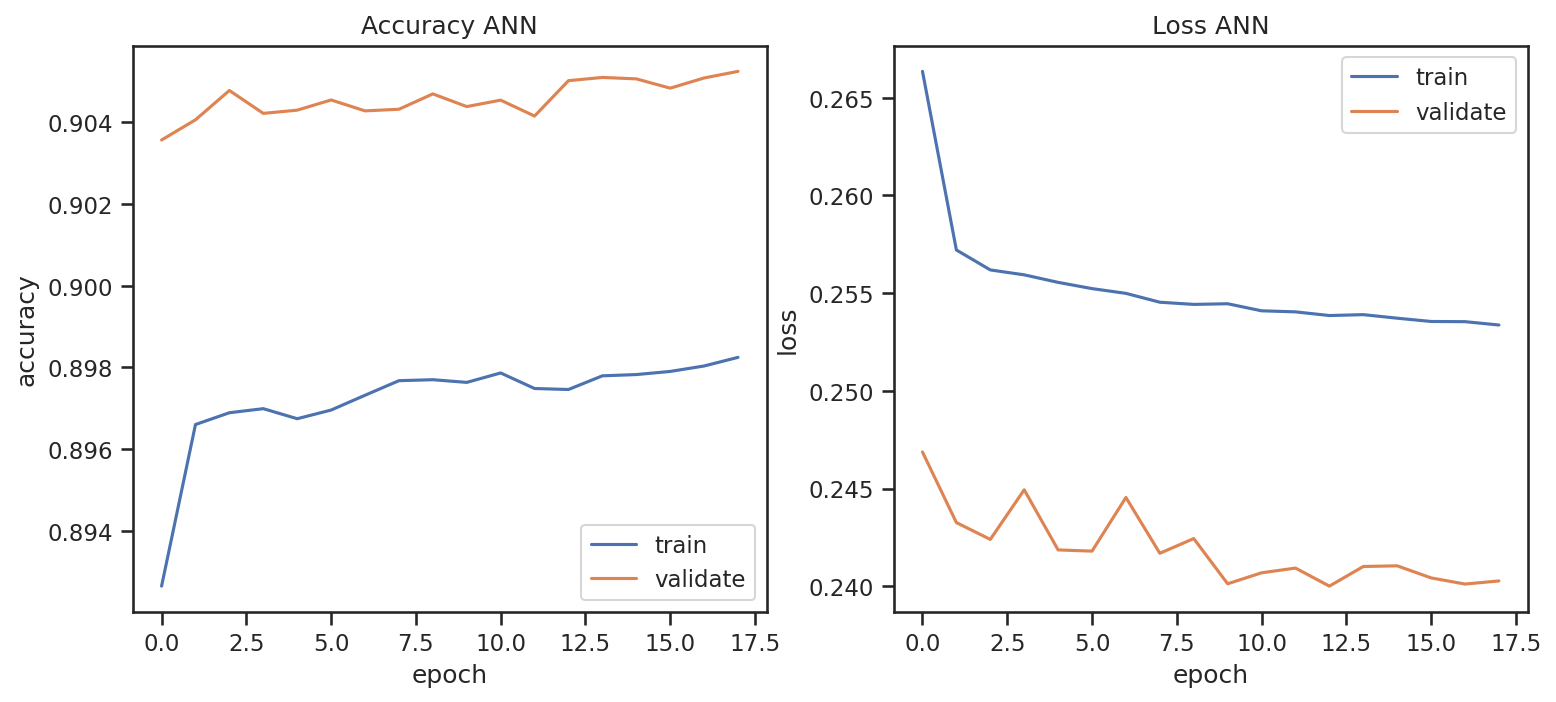

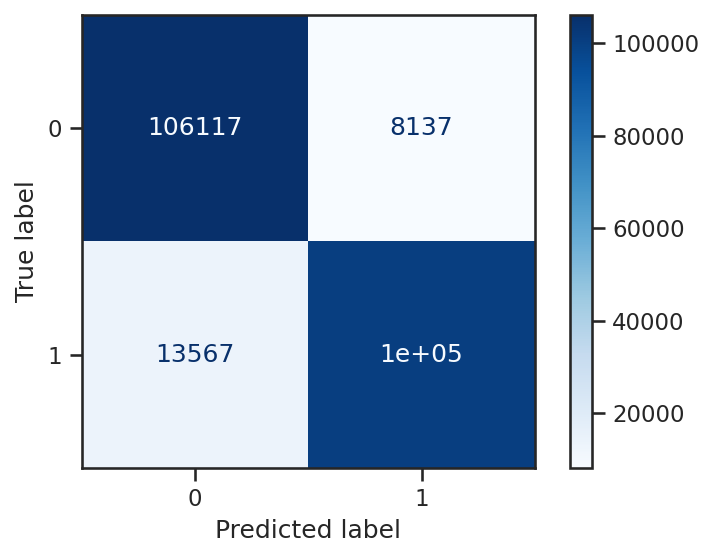

              precision    recall  f1-score   support

           0       0.89      0.93      0.91    114254
           1       0.93      0.88      0.90    114254

    accuracy                           0.91    228508
   macro avg       0.91      0.91      0.90    228508
weighted avg       0.91      0.91      0.90    228508



In [17]:
#@title Modelo ANN (monocapa)
train_model_get_metrics(model_name='ANN',model=get_ANN(max_features,max_len,LOSS_FUNCTION,OPTIMIZER))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 67, 128)           4992      
                                                                 
 dense_2 (Dense)             (None, 67, 64)            8256      
                                                                 
 flatten_1 (Flatten)         (None, 4288)              0         
                                                                 
 dropout_1 (Dropout)         (None, 4288)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                274496    
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dropout_2 (Dropout)         (None, 64)               

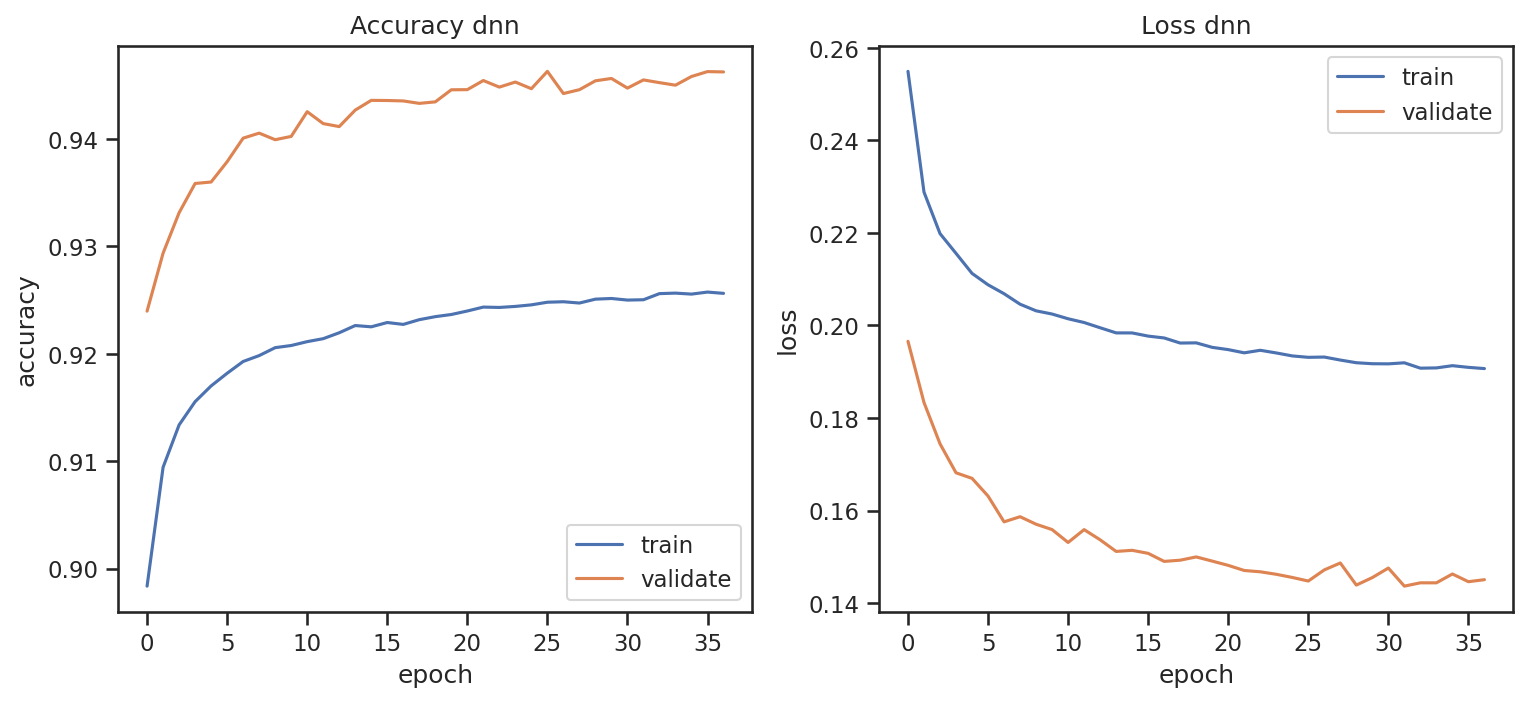

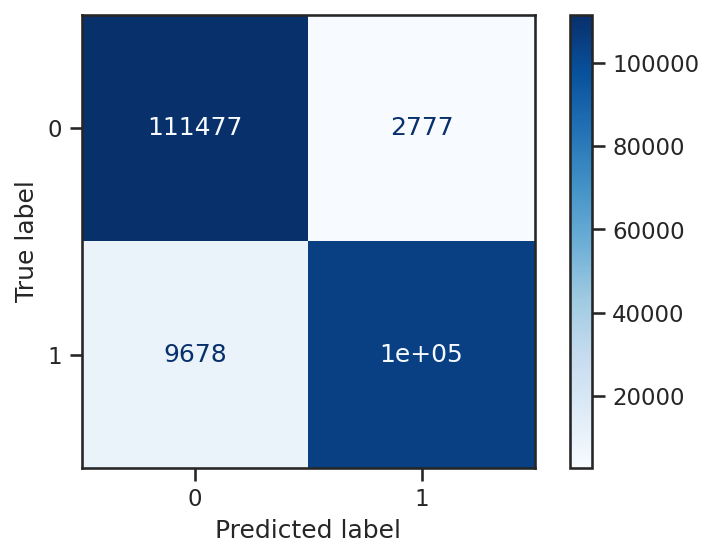

              precision    recall  f1-score   support

           0       0.92      0.98      0.95    114254
           1       0.97      0.92      0.94    114254

    accuracy                           0.95    228508
   macro avg       0.95      0.95      0.95    228508
weighted avg       0.95      0.95      0.95    228508



In [18]:
#@title Modelo DNN (multicapa)
train_model_get_metrics(model_name='dnn',model=get_DNN(max_features,max_len,LOSS_FUNCTION,OPTIMIZER))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 67, 128)           4992      
                                                                 
 lstm (LSTM)                 (None, 67, 128)           131584    
                                                                 
 dropout_3 (Dropout)         (None, 67, 128)           0         
                                                                 
 dense_5 (Dense)             (None, 67, 64)            8256      
                                                                 
 dropout_4 (Dropout)         (None, 67, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_5 (Dropout)         (None, 64)               

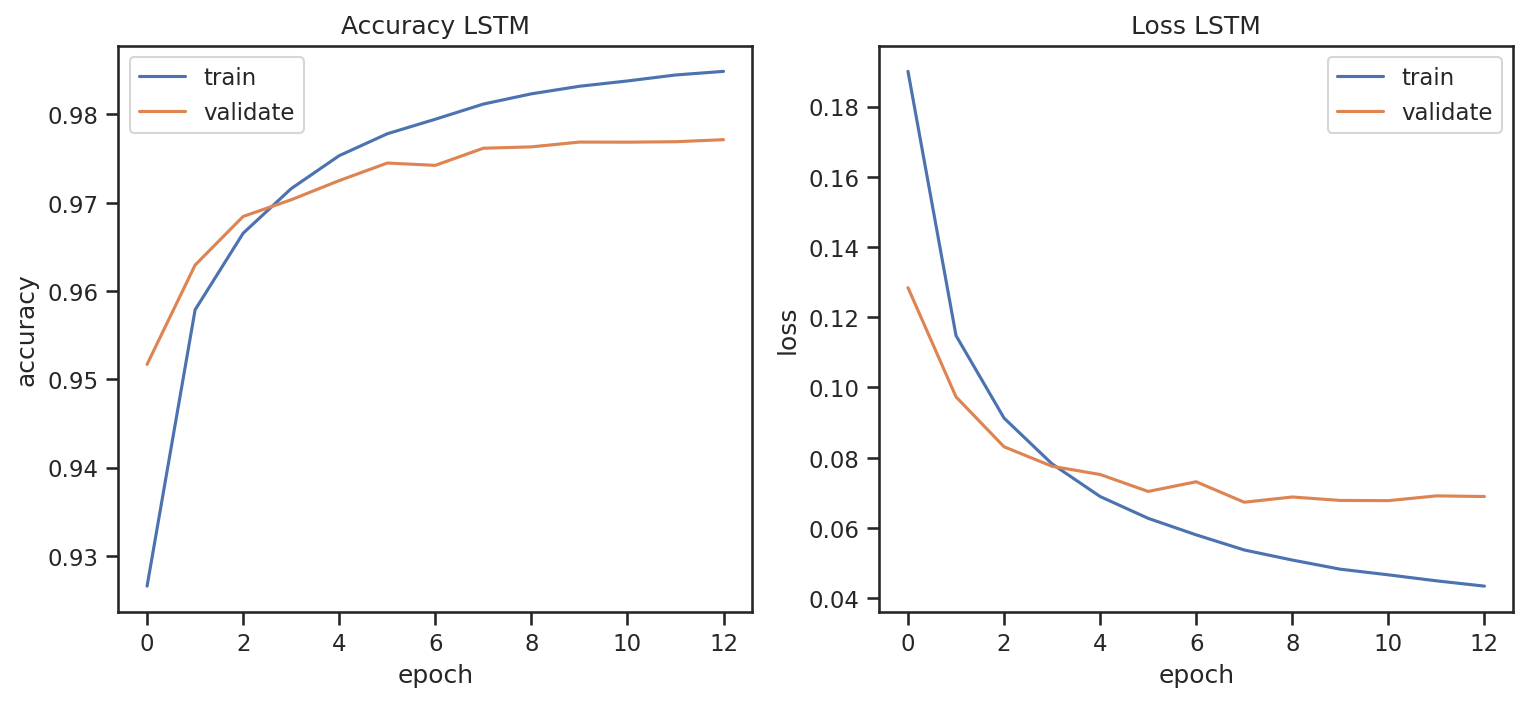

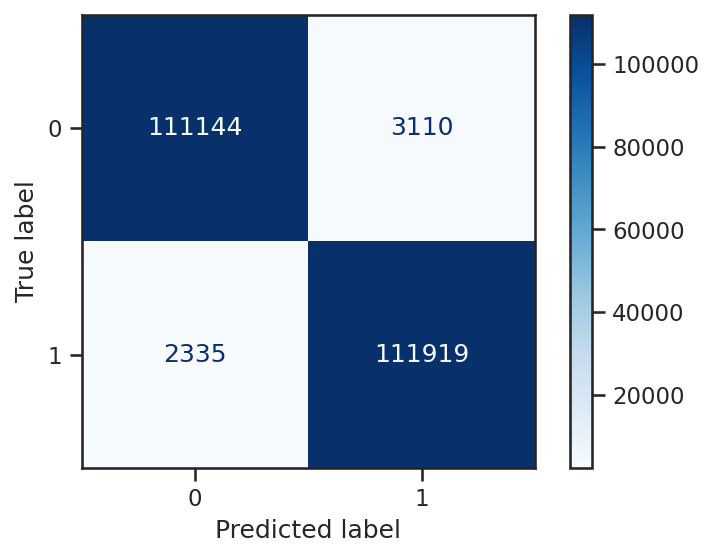

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    114254
           1       0.97      0.98      0.98    114254

    accuracy                           0.98    228508
   macro avg       0.98      0.98      0.98    228508
weighted avg       0.98      0.98      0.98    228508



In [19]:
#@title Modelo RNN (LSTM)
train_model_get_metrics(model_name='LSTM',model=get_LSTM(max_features,max_len,LOSS_FUNCTION,OPTIMIZER))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 67, 128)           4992      
                                                                 
 conv1d (Conv1D)             (None, 67, 256)           164096    
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                      

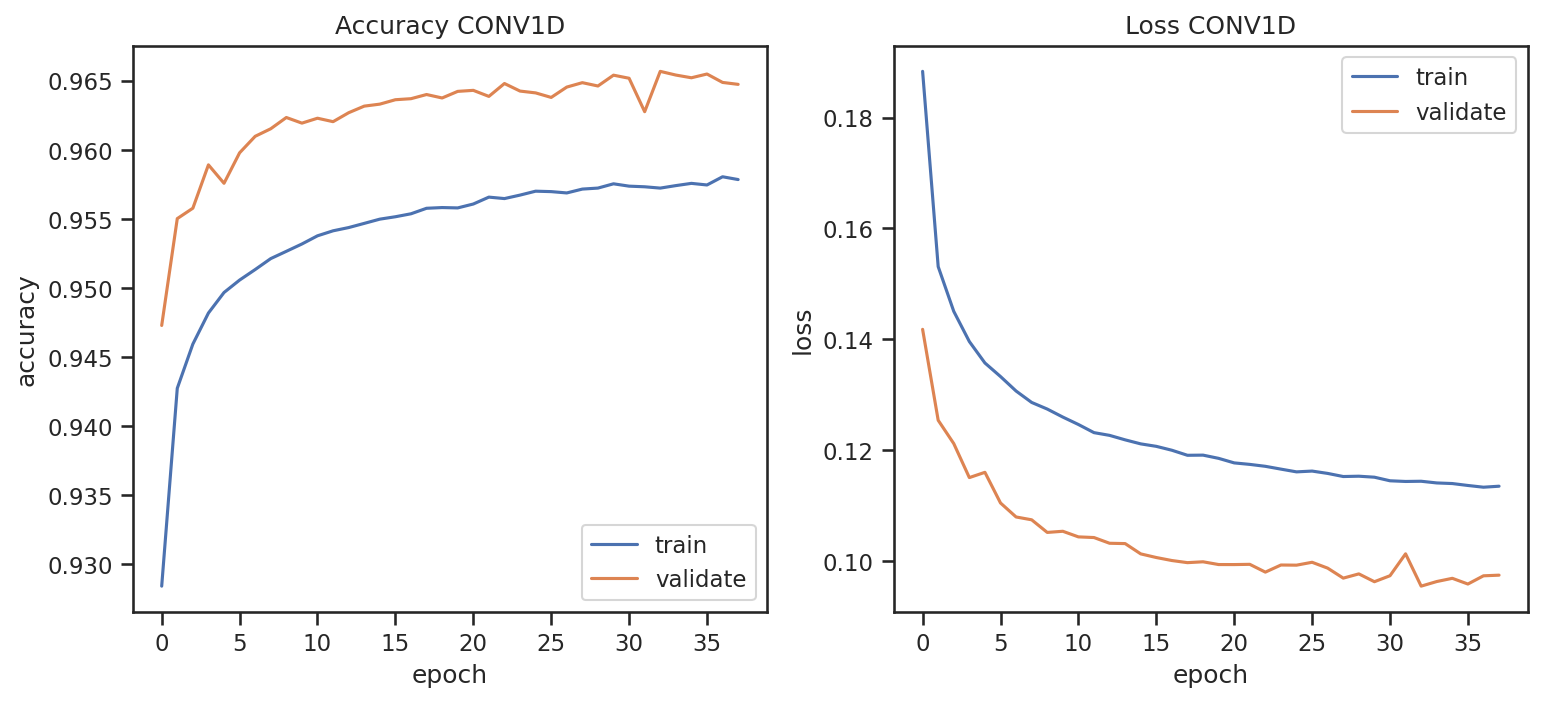

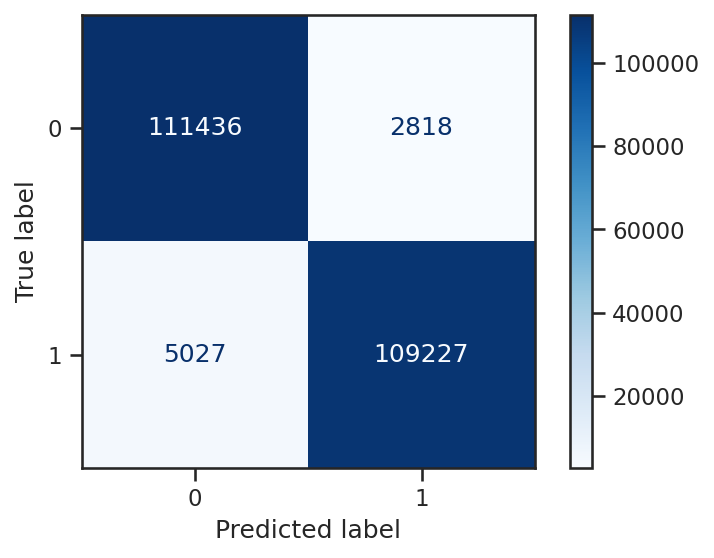

              precision    recall  f1-score   support

           0       0.96      0.98      0.97    114254
           1       0.97      0.96      0.97    114254

    accuracy                           0.97    228508
   macro avg       0.97      0.97      0.97    228508
weighted avg       0.97      0.97      0.97    228508



In [20]:
#@title Modelo CNN (Conv1D)
train_model_get_metrics(model_name='CONV1D',model=get_Conv1D(max_features,max_len,LOSS_FUNCTION,OPTIMIZER))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 67)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 67, 128)      4992        ['text_input[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)              (None, 66, 15)       3855        ['embedding_4[0][0]']            
                                                                                                  
 conv1d_2 (Conv1D)              (None, 64, 15)       7695        ['embedding_4[0][0]']            
                                                                                              

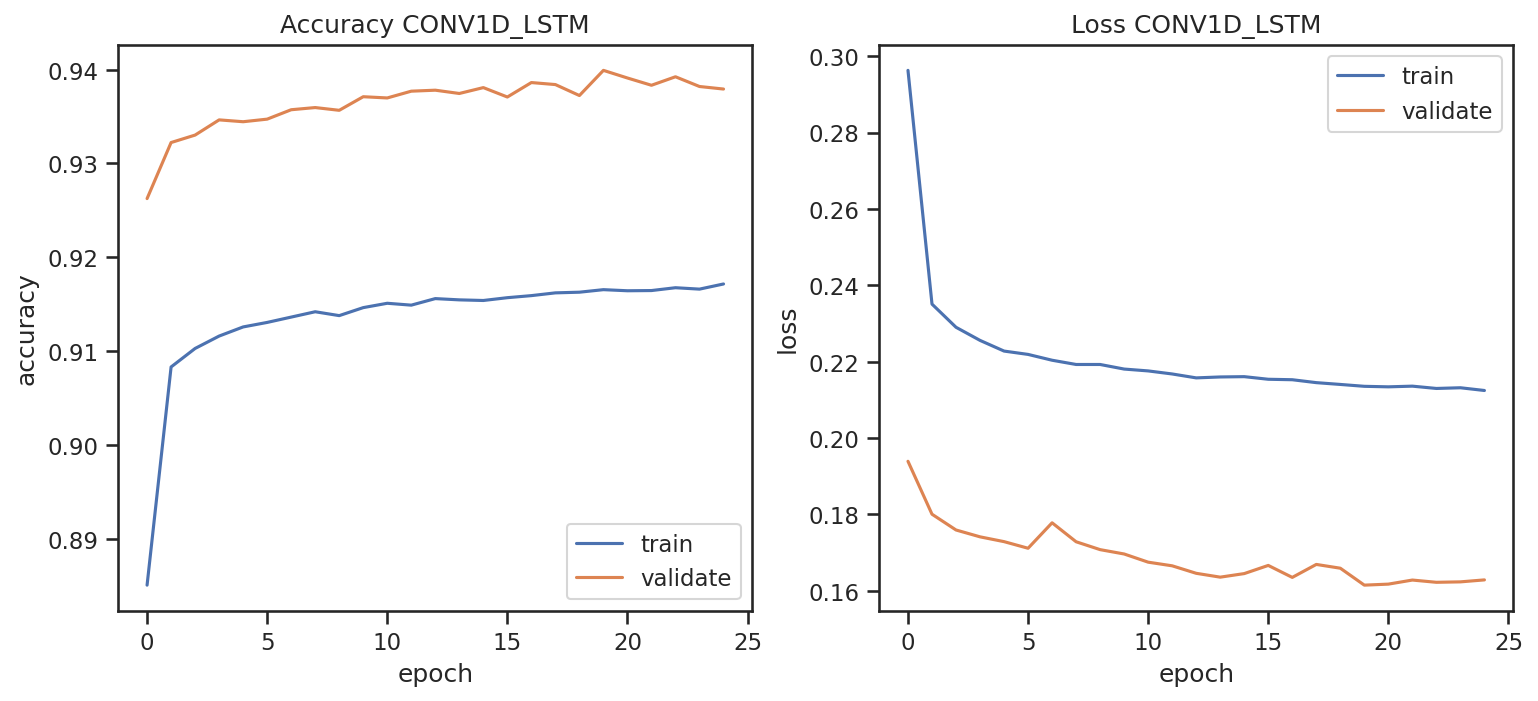

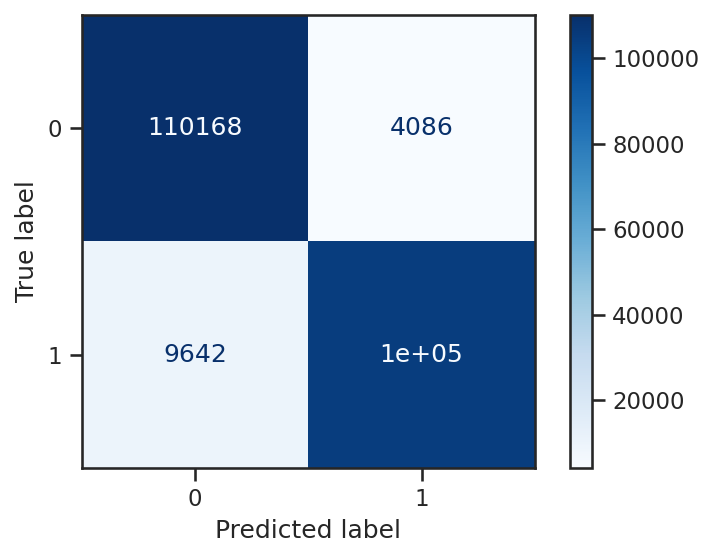

              precision    recall  f1-score   support

           0       0.92      0.96      0.94    114254
           1       0.96      0.92      0.94    114254

    accuracy                           0.94    228508
   macro avg       0.94      0.94      0.94    228508
weighted avg       0.94      0.94      0.94    228508



In [21]:
#@title Modelo mixto LSTM-Conv1D
train_model_get_metrics(model_name='CONV1D_LSTM',model=get_LSTM_Conv1D(max_features,max_len,LOSS_FUNCTION,OPTIMIZER))

# Tabla resumen de resultados
La siguiente tabla resume los resultados obtenidos. 
Se puede observar que los mejores resultados son los ofrecidos por el modelo `LSTM` y por el modelo combinado `LSTM+Conv1D`.


In [22]:
table_content=''
for m in metrics:
  table_content=table_content+'|'+m['model'] \
  +'|'+"{:10.2f}".format(m['acc']) \
  +'|'+"{:10.2f}".format(m['loss']) \
  +'|'+"{:10.3f}".format(m['roc_auc']) \
  +'|'+str(m['params']) \
  +'|'+"{:.0f} s.".format(m['time'])+'|\n'


display(Markdown(
"""
| Modelo | _Accuracy_ | _Loss_ | AUC | Núm. Parámetros | Tiempo entrenamiento |
|--------|------------|--------|-----|-----------------|----------------------|
"""+table_content
))


| Modelo | _Accuracy_ | _Loss_ | AUC | Núm. Parámetros | Tiempo entrenamiento |
|--------|------------|--------|-----|-----------------|----------------------|
|ANN|      0.91|      0.24|     0.962|30081|671 s.|
|dnn|      0.95|      0.14|     0.988|287809|1448 s.|
|LSTM|      0.98|      0.07|     0.997|177921|1507 s.|
|CONV1D|      0.97|      0.10|     0.994|169345|1933 s.|
|CONV1D_LSTM|      0.94|      0.16|     0.983|159806|2330 s.|


Comparamos a continuación los resultados por medio de las curvas ROC:



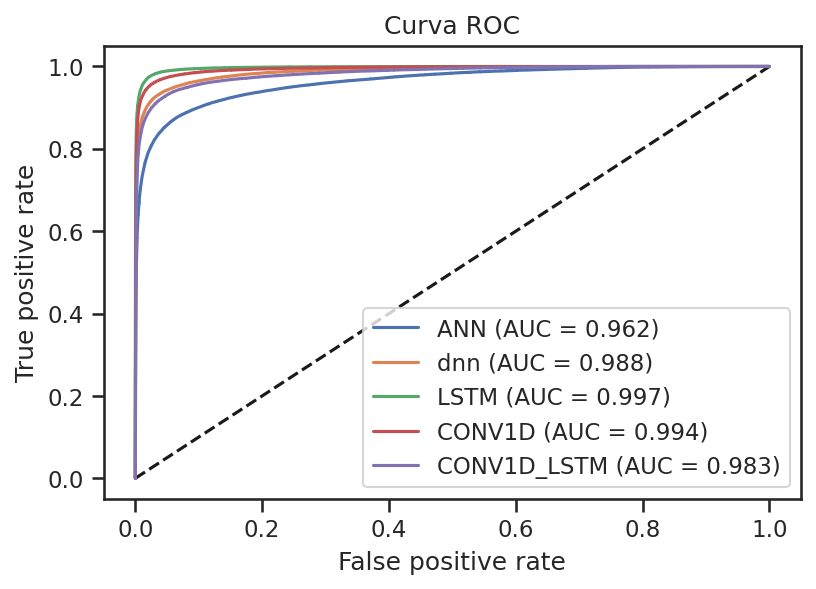

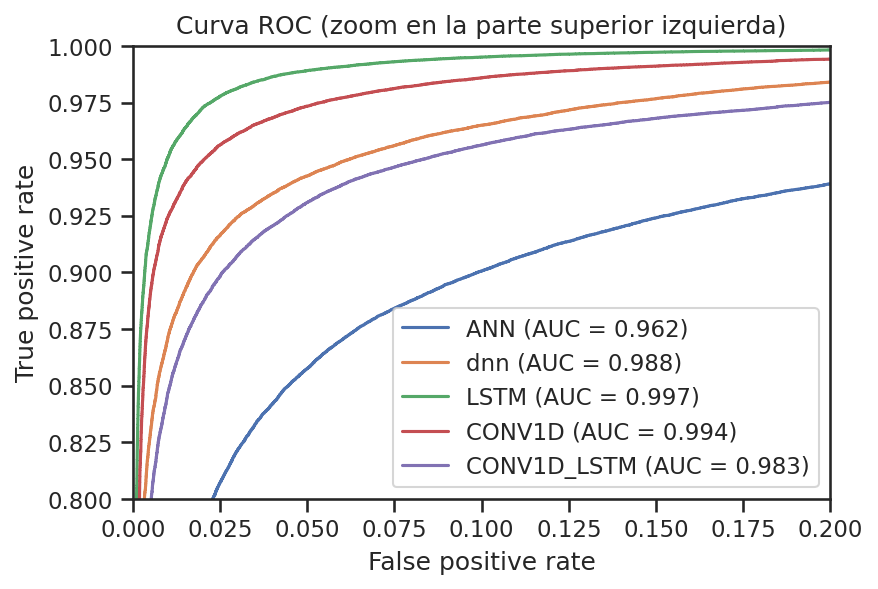

In [23]:
# Ref: https://github.com/Tony607/ROC-Keras/blob/master/ROC-Keras.ipynb
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
for m in metrics:
  plt.plot(m['fpr'],m['tpr'], label=m['model']+' (AUC = {:.3f})'.format(m['roc_auc']))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Curva ROC')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
for m in metrics:
  plt.plot(m['fpr'],m['tpr'], label=m['model']+' (AUC = {:.3f})'.format(m['roc_auc']))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Curva ROC (zoom en la parte superior izquierda)')
plt.legend(loc='best')
plt.show()

# Valoración
[comment]: <> (https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss)
Tanto en las gráficas de _accuracy_ como de _loss_ se puede observar que el _accuracy_ del conjunto de datos de evaluación permanece por encima del conjunto de datos de entrenamiento. Esto se debe a que los mecanismos de regularización, en este caso, _Dropout_, se desactivan en tiempo de _testing_, por lo que afectan el el _loss_ en tiempo de entrenamiento pero no en el _loss_ en tiempo de prueba.

Además, el _loss_ de entrenamiento es la media del _loss_ para cada lote de datos de entrenamiento, sobre el _epoch_ actual. Debido a que el modelo está cambiando durante cada _epoch_, la pérdida sobre los primeros lotes de un _epoch_ es generalmente mayor que sobre los últimos lotes. Esto puede reducir la media por _epoch_. Sin embargo, el _loss_ de prueba para un _epoch_ se calcula utilizando el modelo tal y como es al final del _epoch_, lo que resulta en un _loss_ menor.

